In [1]:
from datetime import date, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from scipy.stats import mannwhitneyu, norm, shapiro
from tqdm.auto import tqdm
from urllib.parse import urlencode

In [8]:
# Блок для отображения всех вычисленных элементов в ячейке
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

Представьте, что мы работаем в компании, которая разрабатывает мобильные игры. К нам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишем функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определим, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложим метрики для оценки результатов последнего прошедшего тематического события в игре.

# 1. Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Данные хранятся на яндекс.диске, ссылки для скачивания:
- reg_data.csv – данные о времени регистрации https://disk.yandex.ru/d/RurhdC-xlKB9XA
- auth_data.csv – данные о времени захода пользователей в игру https://disk.yandex.ru/d/BkcYFOOxuLUJ2w

Функцию напишем на python

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
name_dict = {'reg_data': 'https://disk.yandex.ru/d/RurhdC-xlKB9XA',
             'auth_data': 'https://disk.yandex.ru/d/BkcYFOOxuLUJ2w'}
# Получаем загрузочную ссылку
for key, value in name_dict.items():
    final_url = base_url + urlencode(dict(public_key=value))
    response = requests.get(final_url)
    download_url = response.json()['href']
    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    with open(f'{key}.csv', 'wb') as f:   # Здесь укажите нужный путь к файлу
        f.write(download_response.content)

In [3]:
# Считаем данные из файлов
auth_df = pd.read_csv('auth_data.csv', sep=';')
reg_df = pd.read_csv('reg_data.csv', sep=';')

In [4]:
auth_df.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [5]:
reg_df.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [6]:
# проверим наличие пустых ячеек
auth_df.isna().sum()
reg_df.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [9]:
# проверим число уникальныых id
auth_df.uid.nunique()
reg_df.uid.nunique()

1000000

1000000

In [10]:
# Данные времени представлены в формате timestamp - время в секундах от 1970 года, переведем значения к формату date
auth_df.auth_ts = auth_df.auth_ts.apply(lambda x: datetime.fromtimestamp(x).date())
reg_df.reg_ts = reg_df.reg_ts.apply(lambda x: datetime.fromtimestamp(x).date())
# Переименуем колонки
auth_df.rename(columns={'auth_ts': 'auth_date', 'uid': 'user_id'}, inplace=True)
reg_df.rename(columns={'reg_ts': 'reg_date', 'uid': 'user_id'}, inplace=True)

In [11]:
# Данная функция принимает на вход предобработанные датафреймы
def Cohort(auth_df, reg_df):
    """Функция принимает два датафрейма и позволяет получить
    в зависимости от указанных в процессе выполнения функции данных
    retention для выбранного диапазона дат в формате дневного, недельного
    и месячного показателей в виде графика (heatmap) или таблицы"""
# задаем переменную для начального сравнения
    period_start = ''
# цикл выполняется ,пока дата равна сегодняшней или пока формат 
# переменной period_start не станет date
    while period_start == datetime.now().date() or not isinstance(period_start, date):
        # строка ввода
        period_start = input(f"""Введите дату начала периода когортного анализа в формате 
    yyyy-mm-dd (не позднее {reg_df.reg_date.max()}): """)
# цикл для отбрасывания пустой строки
        if period_start == '':
            period_start = datetime.now().date()
        else:
            # если введенное значение не преобразуется в формат date, то цикл начинается заново
            try:
                period_start = pd.to_datetime(period_start).date()
                while period_start >= reg_df.reg_date.max():
                    period_start = ''
            except Exception:
                continue
# аналогично дате period_end
    period_end = ''
# пока тип переменной не станет date - цикл будет повторяться
    while not isinstance(period_end, date):
        period_end = input("Введите дату окончания периода когортного анализа(enter, если по текущую дату): ")
        if not period_end:
            period_end = datetime.now().date()
        else:
            try:
                period_end = pd.to_datetime(period_end).date()
                while period_start > period_end:
                    period_end = ''
            except Exception:
                continue
# фильтруем датафрейм по введенным датам
    reg_df = reg_df.loc[(reg_df['reg_date'] >= period_start) & (reg_df['reg_date'] <= period_end)]
# объединяем датафреймы в один по колонке user_id левым типом join
    Cohort_df = auth_df.merge(reg_df, how='left', on='user_id')
# убираем строки, которые имеют пустые значения(это пользователи, не попавшие в введенный диапазон
    Cohort_df.dropna(inplace=True)
# переименуем колонку reg_date
    Cohort_df.rename(columns={'reg_date': 'Cohort'}, inplace=True)
# вводим тип разбивки для отображения
    string = input('Укажите, retention для какого типа даты необходим (день, неделя, месяц): ')
    array = ['день', 'неделя', 'месяц']
# просим ввести значение из доступных
    while string not in array:
        string = input(f'Введите один из вариантов {array}: ')
# если выбран retention по дням:
    if string == array[0]:
        n = ''
# цикл повторяется пока не введут число больше 0
        while not isinstance(n, int):
            n = input('Введите число дней для оценки retention: ')
            try:
                n = int(n)
                if n <= 0:
                    n = ''
            except Exception:
                continue
# создаем колонку разницы между ключевым действием и регистрацией в днях
        Cohort_df['day'] = (Cohort_df['auth_date'] - Cohort_df['Cohort']).dt.days
# фильтруем датафрейм по введенному числу дней
        Cohort_df = Cohort_df.query('day <= @n')
# группируем по когортам и числу дней, считаем число уникальных пользователей
        Table_df = Cohort_df.groupby(['Cohort', 'day'], as_index=False).agg({'user_id': 'nunique'})
# преобразуем таблицу к требуемому виду
        Retention_df = Table_df.pivot(index='Cohort', columns='day', values='user_id')
# если выбран retention по неделям
    elif string == array[1]:
        n = ''
        while not isinstance(n, int):
            n = input('Введите число недель для оценки retention: ')
            try:
                n = int(n)
                if n <= 0:
                    n = ''
            except Exception:
                continue
# создаем колонку разницы между целевым действием и регистрацией в неделях
        Cohort_df['week'] = (52 * (Cohort_df['auth_date'].apply(lambda x: x.year) -
                                   Cohort_df['Cohort'].apply(lambda x: x.year)) +
                             (Cohort_df.auth_date.apply(lambda x: int(x.strftime("%U"))) - 
                              Cohort_df.Cohort.apply(lambda x: int(x.strftime("%U")))))
        Cohort_df = Cohort_df.query('week <= @n')
# преобразуем отображение данных к удобному формату год-номер недели
        Cohort_df['Cohort'] = Cohort_df['Cohort'].apply(lambda x: x.strftime("%Y-%U"))
        Table_df = Cohort_df.groupby(['Cohort', 'week'], as_index=False).agg({'user_id': 'nunique'})
        Retention_df = Table_df.pivot(index='Cohort', columns='week', values='user_id')
# если выбран retention по месяцам
    else:
        n = ''
        while not isinstance(n, int):
            n = input('Введите число месяцев для оценки retention: ')
            try:
                n = int(n)
                if n <= 0:
                    n = ''
            except Exception:
                continue
# создаем колонку разницы между ключевым действием и регистрацией в месяцах
        Cohort_df['month'] = (12 * (Cohort_df['auth_date'].apply(lambda x: x.year) -
                                    Cohort_df['Cohort'].apply(lambda x: x.year)) +
                              (Cohort_df['auth_date'].apply(lambda x: x.month) -
                               Cohort_df['Cohort'].apply(lambda x: x.month)))
        Cohort_df['Cohort'] = Cohort_df.Cohort.apply(lambda x: x.strftime('%Y-%m'))
        Cohort_df = Cohort_df.query('month <= @n')
        Table_df = Cohort_df.groupby(['Cohort', 'month'], as_index=False).agg({'user_id': 'nunique'})
        Retention_df = Table_df.pivot(index='Cohort', columns='month', values='user_id')
# вводим удобный для анализа формат отображения - таблица или heatmap
    vision = input('Укажите, в каком формате вывести данные (таблица или график): ')
    vis_arr = ['таблица', 'график']
    while vision not in vis_arr:
        vision = input(f'Введите один из вариантов {vis_arr}: ')
# если указан график
    if vision == vis_arr[1]:
        # делим все значения на первую колонку датафрейма (число пользователей когорты)
        Retention_df = Retention_df.div(Retention_df[0], axis=0)
        # указываем параметры графика
        sns.set(style='ticks', font_scale=2)
        plt.figure(figsize=(50, 20))
        plt.title('Cohorts: User Retention')
        return sns.heatmap(Retention_df, mask=Retention_df.isnull(), annot=True,
                           fmt='.2%', vmin=0.0, vmax=0.1, cmap='Blues')
# если указана таблица
    else:
        # переименуем колонку 0 в Users - она отображает число пользователей в когорте
        Retention_df = Retention_df.rename(columns={Retention_df.columns[0]: 'Users'})
        # форматируем retention rate - делим число вернувшихся пользователей на общее число когорты
        columns = [i for i in range(1, Retention_df.shape[1])]
        Retention_df.iloc[:, columns] = (Retention_df.iloc[:, columns].div(Retention_df['Users'], axis=0))
        # убираем знаки после запятой в численности когорты
        Retention_df["Users"] = Retention_df['Users'].astype(int)
        # приводим таблицу к красивому виду
        Retention_df.reset_index(inplace=True)
        Retention_df.set_index(['Cohort', 'Users'], inplace=True)
        return Retention_df.style.format('{:.2%}', na_rep='',
                                         subset=[i for i in range(1, Retention_df.shape[1] + 1)])

Введите дату начала периода когортного анализа в формате 
    yyyy-mm-dd (не позднее 2020-09-23): 2020-09-01
Введите дату окончания периода когортного анализа(enter, если по текущую дату): 
Укажите, retention для какого типа даты необходим (день, неделя, месяц): день
Введите число дней для оценки retention: 30
Укажите, в каком формате вывести данные (таблица или график): график


<AxesSubplot:title={'center':'Cohorts: User Retention'}, xlabel='day', ylabel='Cohort'>

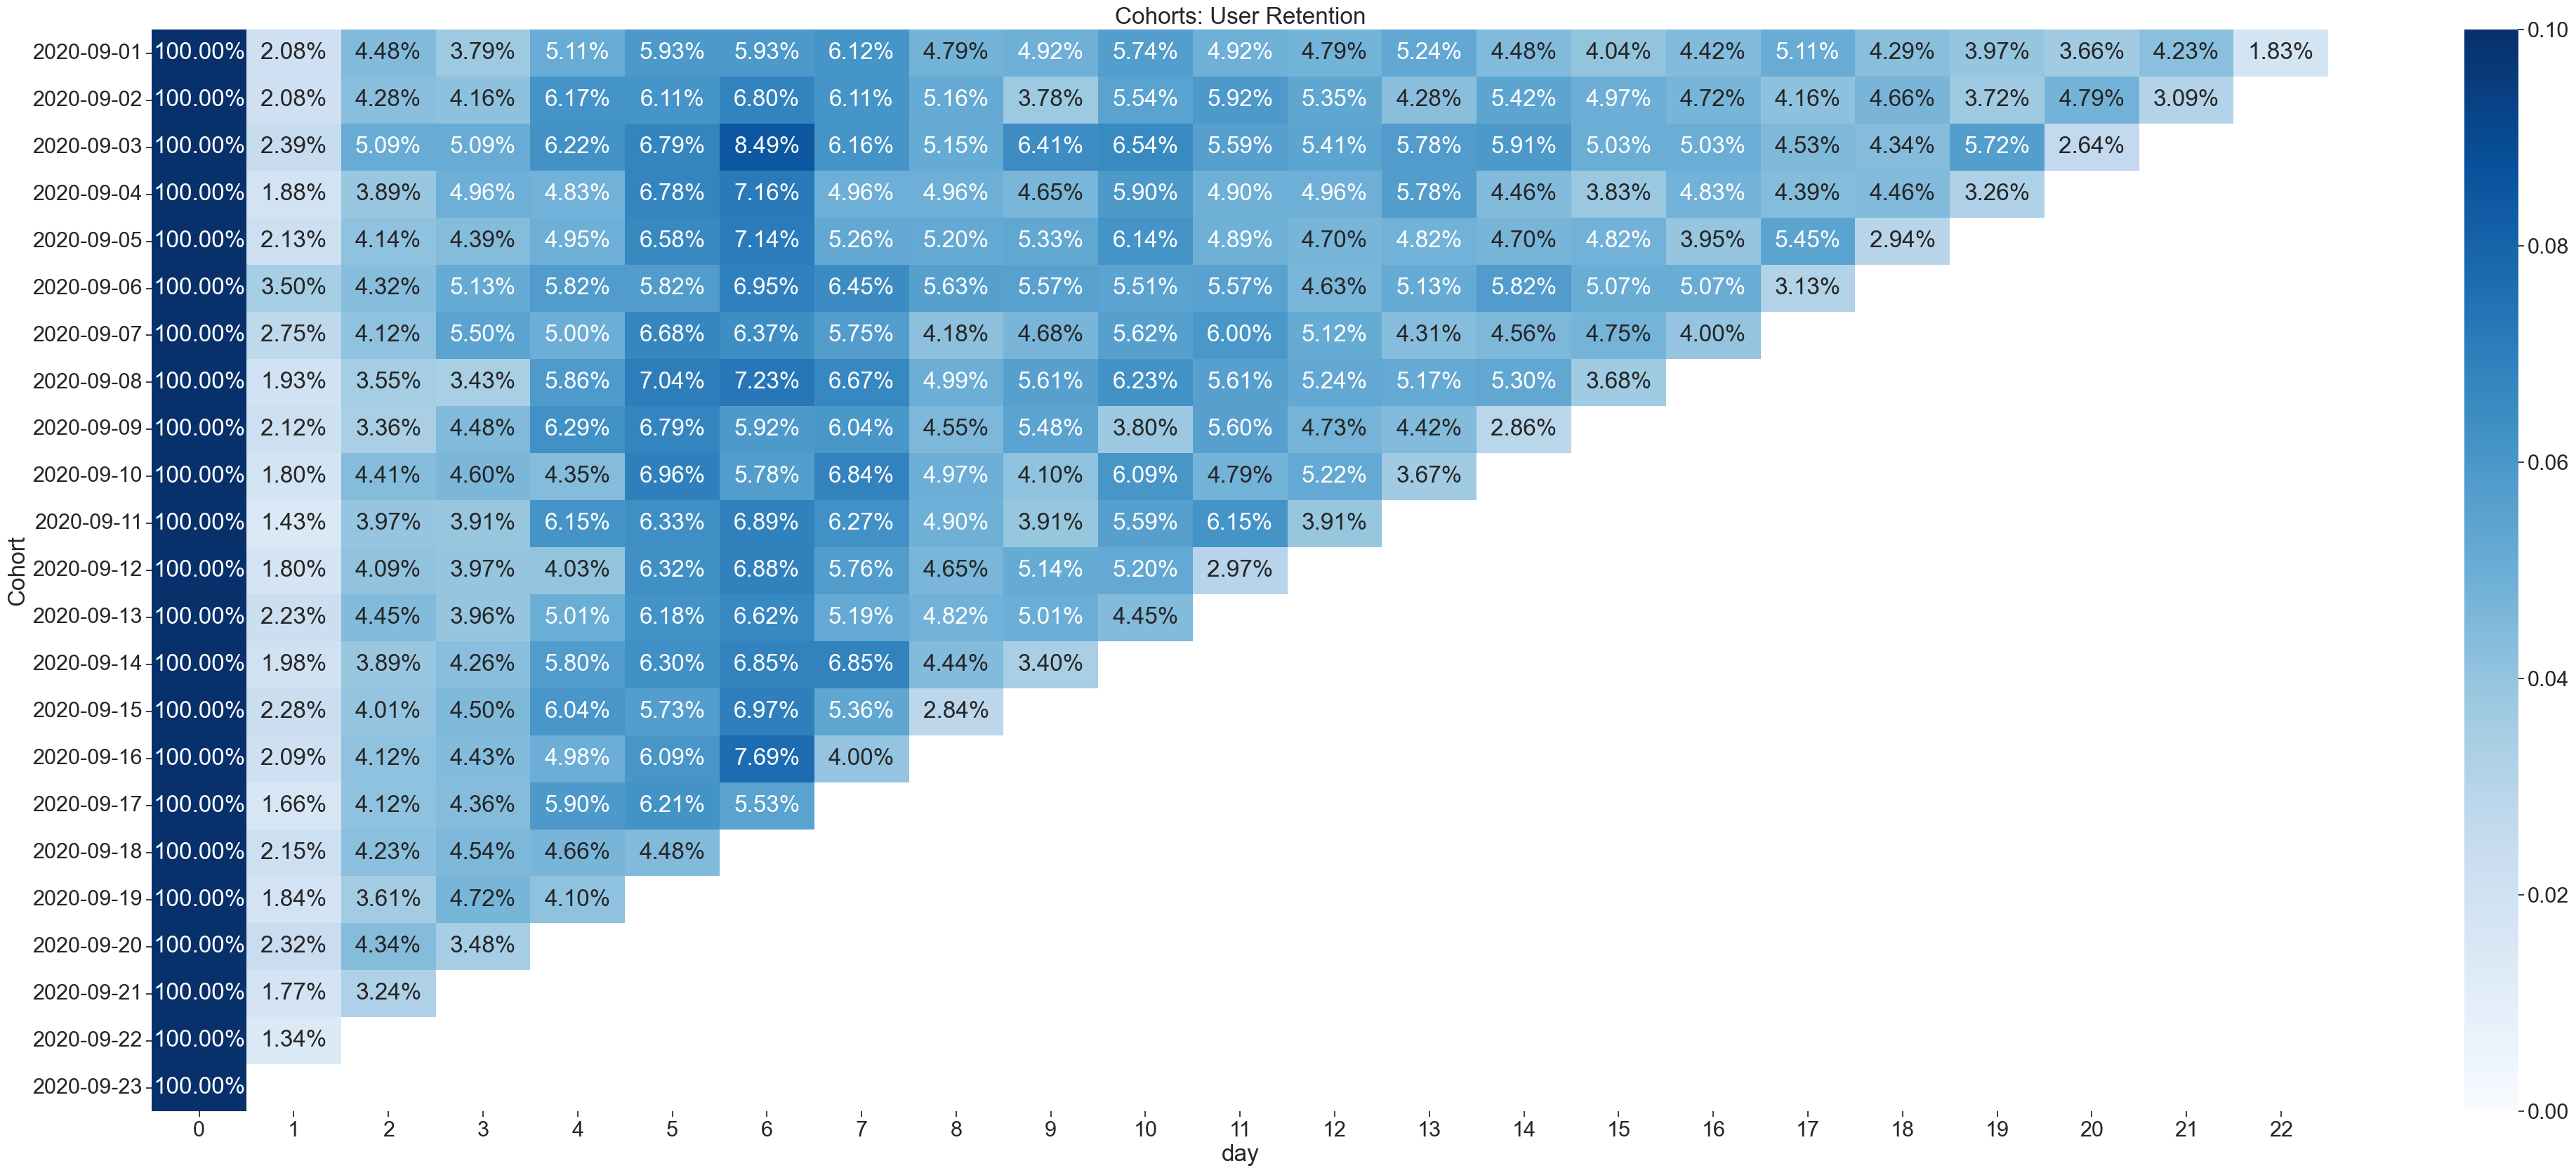

In [21]:
# Пример реализации когортного анализа по дневным когортам в виде графика
Cohort(auth_df, reg_df)

## 2. Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Для начала выгрузим данные и посмотрим на формат, данные хранятся по ссылке: https://disk.yandex.ru/d/Rz0uZ3m7hpx1zA

In [12]:
# скачиваем данные по ссылке из yandex.disk и сохраняем в файле Project_2.csv
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
url = 'https://disk.yandex.ru/d/Rz0uZ3m7hpx1zA'
final_url = base_url + urlencode(dict(public_key=url))
response = requests.get(final_url)
download_url = response.json()['href']
# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('Project_2.csv', 'wb') as f:
    f.write(download_response.content)

4350908

In [23]:
# Создадим датафрейм и посмотрим на структуру
df = pd.read_csv('Project_2.csv', sep=';')

df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Определим, какая из двух групп является контрольной, а какая тестовой, найдем средние значения:

In [26]:
df.query('testgroup == "a"').revenue.mean()
df.query('testgroup == "b"').revenue.mean()

25.413719736965806

26.75128659327863

Известно, что средний чек тестовой группы выше на 5%, значит группа b - тестовая, а - контрольная

Таблица состоит из revenue на пользователя и группы, к которой он принадлежит. Нам известно, что средняя прибыль с пользователя (ARPU) отличается на 5%.
Проведем А/Б тестирование, чтобы убедиться, что значения revenue стаистически значимы. Для выбора метода тестирования, проверим распределение величин на нормальность

Посмотрим на распределение revenue по группам пользователей и проверим распределение на нормальность

In [27]:
control_group = df.query('testgroup == "a"').revenue
test_group = df.query('testgroup == "b"').revenue

Для проверки нормальности распределения берем тест Шапиро

In [30]:
shapiro(control_group.sample(3000))
shapiro(test_group.sample(3000))

ShapiroResult(statistic=0.018445193767547607, pvalue=0.0)

ShapiroResult(statistic=0.07216125726699829, pvalue=0.0)

p-value в обоих случаях = 0, что значит, что распределения ненормальные, поэтому используем для анализа непараметрический тест Манна-Уитни

In [31]:
mannwhitneyu(control_group, test_group)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

p-value > 0.05, поэтому принимаем нулевую гипотезу об одинаковости распределений и делаем вывод, что статистически значимых различий в распеределениях двух групп нет, поэтому различие метрики ARPU нельзя считать значимым

Теперь проверим группы платящих пользователей

In [32]:
# доп фильтр по revenue
control_group_p = df.query('testgroup == "a" and revenue != 0').revenue
test_group_p = df.query('testgroup == "b" and revenue != 0').revenue

In [33]:
# тест на нромальность
shapiro(control_group_p)
shapiro(test_group_p)

ShapiroResult(statistic=0.2667924165725708, pvalue=0.0)

ShapiroResult(statistic=0.9583134651184082, pvalue=2.4929213770979496e-22)

распределения также не являются нормальными, проводим тест Манна-Уитни

In [34]:
mannwhitneyu(control_group_p, test_group_p)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

p-value = 0, следовательно отклоняем нулевую гипотезу об одинаковости распределений двух групп и делаем вывод, что данные в группах платящих пользователей различаются статистически значимо

ARPPU - average rate per paying user, средний чек на платящего пользователя, определим, насколько отличается

In [35]:
ARPPU_control = control_group_p.mean()
ARPPU_test = test_group_p.mean()
print(f"""Величина ARPPU контрольной группы: {round(ARPPU_control, 2)} руб.,
Величина ARPPU тестовой группы {round(ARPPU_test, 2)} руб, 
Разница в процентах: {"{0:.2%}".format((ARPPU_test - ARPPU_control) / ARPPU_test)}""")

Величина ARPPU контрольной группы: 2664.0 руб.,
Величина ARPPU тестовой группы 3003.66 руб, 
Разница в процентах: 11.31%


Также проведем анализ с помощью бутстрапа для проверки, на каких сегментах платящих пользователей значения статистически значимо отличаются

In [36]:
# измененная функция для расчета различий по квантилям
def get_bootstrap_quan(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    answer = pd.DataFrame(columns=['quantile', 'p_value', 'first_data_value', 'second_data_value', 'difference'])
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    p_values = {}   
    for elem in np.arange(0.1, 1, 0.1):
        for i in tqdm(range(boot_it)):  # извлекаем подвыборки
            samples_1 = data_column_1.sample(
                boot_len, 
                replace=True  # параметр возвращения
            ).values

            samples_2 = data_column_2.sample(
                boot_len, 
                replace=True
            ).values

            boot_data.append(np.quantile(samples_1, q=elem) - np.quantile(samples_2, q=elem))

        p_1 = norm.cdf(
            x=0, 
            loc=np.mean(boot_data), 
            scale=np.std(boot_data)
        )
        p_2 = norm.cdf(
            x=0, 
            loc=-np.mean(boot_data), 
            scale=np.std(boot_data)
        )
        p_value = min(p_1, p_2) * 2
        elem = "{0:.1f}".format(elem)
        p_values[elem] = p_value
    for quan, p_value in p_values.items():
        first_data_value = data_column_1.quantile(q=float(quan))
        second_data_value = data_column_2.quantile(q=float(quan))
        if p_value < 0.05:
            diff = '{0:.2%}'.format((second_data_value - first_data_value) / second_data_value)
            row = {'quantile': quan, 'p_value': p_value, 
                   'first_data_value': first_data_value,
                   'second_data_value': second_data_value,
                   'difference': diff}
            answer = answer.append(row, ignore_index=True)
        else:
            row = {'quantile': quan, 'p_value': p_value}
            answer = answer.append(row, ignore_index=True) 
    return answer

In [37]:
get_bootstrap_quan(control_group_p, test_group_p)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\DimDolino\AppData\Local\Temp\ipykernel_10772\2879840347.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  answer = answer.append(row, ignore_index=True)
C:\Users\DimDolino\AppData\Local\Temp\ipykernel_10772\2879840347.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  answer = answer.append(row, ignore_index=True)
C:\Users\DimDolino\AppData\Local\Temp\ipykernel_10772\2879840347.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  answer = answer.append(row, ignore_index=True)
C:\Users\DimDolino\AppData\Local\Temp\ipykernel_10772\2879840347.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  answer = answer.append(row, ign

,quantile,p_value,first_data_value,second_data_value,difference
0,0.1,0.000000e+00,221.0,2202.4,89.97%
1,0.2,2.018696e-105,246.0,2408.0,89.78%
2,0.3,6.380769e-44,267.0,2624.4,89.83%
3,0.4,4.713894e-28,290.0,2810.2,89.68%
4,0.5,1.038004e-19,311.0,3022.0,89.71%
5,0.6,2.851749e-15,333.2,3211.0,89.62%
6,0.7,1.578404e-12,351.9,3404.0,89.66%
7,0.8,7.641350e-11,372.6,3561.6,89.54%
8,0.9,2.632688e-09,393.3,3795.8,89.64%


Значения по квантилям отличаются на 89% на всем интервале значений

## Итак, в ходе выполнени задания:
### - произвели анализ данных в обеих группах на нормальность распределения, с помощью теста Шапиро-Уилка выявили ненормальность распределения в обеих группах
### - т.к. распределения ненормальные, использовали для сравнения групп непараметрический тест Манна-Уитни (ранговый), получили p-уровень значимости > 0.05, что говорит о невозможности отклонения нулевой гипотезы о равенстве выборок, и, следовательно, о статистически незначимом различии средних значений в данных группах.
### - взяли из групп только платящих пользователей и также провели тест на нормальность распределения, который приводит к выводу о ненормальном распределении в обеих группах.
### - Для дальнейшего сравнения групп выполнили тест Манна-Уитни и получили p-уровень значимости = 0, следовательно, средние значения в ГС двух выборок не равны и выборки отличаются статистически значимо.
### - Определили, что  разница в ARPPU двух групп(средний чек), составляет 11,31%
### - с помощью бутстрапа выяснили, на каких децилях распределения revenue различия статистически значимы, получили стат значимые различия на всех децилях распределения в 89%
### - Так как получили, что чеки всех платящих пользователей по децилям в тестовой группе выше чем в контрольной, имеет смысл проверять перед А/Б тестом с помощью А/А тестирования группы пользователей (могут быть различия в сегментах)


## Таким образом, пользователи тестовой группы увеличили свои чеки во всех децилях платящих пользователей, поэтому делаем вывод, что акции в тестовой группе привели к улучшенным показателям метрики ARPPU и данный набор акций можно применять на всех пользователях (выкатывать в продакшн)

## 3. В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Метрики для анализа результатов события:
- DAU - daily active users - число активных пользователей за день
- WAU
- MAU - для сравнения числа игроков с предыдущими событиями
- LTV - lifetime value
- retention по дням
- распределение пользователей по последней награде в цепочке событий, которую они получили (на какой остановились)
- конверсия в следующую награду в цепочке событий
- процент платящих пользователей от общего числа игроков, зашедших в этом месяце
- среднее время прохождения цепочки событий
- различие в конверсии у платящих игроков и неплатящих по наградам
- ARPU, ARPPU
- среднее время в игре

В случае усложнения механики событий набор метрик оценки результата увеличится, к текущим необходимо добавить:
- распределение уровней по числу неудачных попыток пользователей
- А/Б тест для проверки влияния новой механики на поведение игроков (сравнить все перечисленные метрики в двух группах)
- распределение числа попыток на прохождение уровня по уровням (какая попытка по номеру станет для игрока успешной)
- распределение числа откатов, которое повлекло выход пользователя из игры (больше не заходил)
